In [1]:
import konlpy
import gensim
import sklearn
import seaborn

import matplotlib.pyplot as plt

from numpy import dot
from numpy.linalg import norm

import re
from konlpy.tag import Okt, Kkma, Komoran, Hannanum, Mecab
from collections import Counter
import os
import json

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import defaultdict  
from collections import OrderedDict

# STEP 0. 데이터를 로드하시오!!!

## 데이터 Load

In [2]:
data = list()

# 파일 읽기
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: 
            break
        data.append(line)

In [3]:
print(len(data))

71156


# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

### 시간이 오래 걸려서 Mecab 위주로 실행.

In [4]:
mecab = Mecab()

nouns = {
    'mecabs' : [],
}

In [5]:
print(f'전체 : {71156}')
print('mecabs')
for idx, line in enumerate(data):
    if idx % 3000 == 0  :
        print(idx)
    mecabs = [word for word in mecab.nouns(line) ]
    nouns['mecabs'].append(mecabs)
# JSON 파일로 저장
with open('nouns_mecabs.json', 'w', encoding='utf-8') as json_file:
    json.dump(nouns, json_file, ensure_ascii=False, indent=4)

전체 : 71156
mecabs
0
3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000
42000
45000
48000
51000
54000
57000
60000
63000
66000
69000


# STEP 2. 추출된 결과로 embedding model 만들기

## json 불러오기

In [8]:
# JSON 파일을 읽어서 데이터를 저장할 변수
loaded_data = None

# JSON 파일을 불러오는 부분
with open('nouns_mecabs.json', 'r', encoding='utf-8') as json_file:
    loaded_data = json.load(json_file)

# 불러온 데이터를 사용하는 예시
if loaded_data is not None:
    print('JSON 파일을 불러오는데 성공했습니다.')
#     for item in loaded_data:
#         print(item)
else:
    print("JSON 파일을 불러오는데 실패했습니다.")


JSON 파일을 불러오는데 성공했습니다.


In [9]:
tokenized = loaded_data['mecabs']

In [10]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8795980215072632),
 ('다큐멘터리', 0.8578189015388489),
 ('드라마', 0.8486306667327881),
 ('코미디', 0.8230820894241333),
 ('옴니버스', 0.8206188678741455),
 ('소재', 0.8181180953979492),
 ('주제', 0.8104267716407776),
 ('형식', 0.8057054877281189),
 ('실제', 0.8035720586776733),
 ('편', 0.8022173643112183)]

In [61]:
model.wv.most_similar(positive=['남자'])

[('여자', 0.9523717761039734),
 ('아메', 0.7626373171806335),
 ('하룻밤', 0.7526801824569702),
 ('베나', 0.7317997813224792),
 ('종두', 0.7312301397323608),
 ('쥘', 0.7185044288635254),
 ('처제', 0.7172055244445801),
 ('여인', 0.7165116667747498),
 ('민우', 0.7115514874458313),
 ('형부', 0.7110059857368469)]

In [60]:
model.wv.most_similar(positive=['여자'])

[('남자', 0.9523717164993286),
 ('유진', 0.7237977385520935),
 ('베나', 0.7230976223945618),
 ('종두', 0.7199608087539673),
 ('처제', 0.7177855968475342),
 ('민우', 0.7177147269248962),
 ('아메', 0.7172549962997437),
 ('하룻밤', 0.7133793830871582),
 ('쥘', 0.7133601903915405),
 ('중년', 0.7045881152153015)]

### `most_similar` 결과

- 남자, 여자를 입력하면 상당히 비슷한 결과가 나온다. 아무래도 학습한 데이터 안에 있는 내용이 남자와 여자에 대한 차별성(?)이 없기에 비슷한 결과가 나온 것으로 추정된다.


# STEP 3. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 `문제점`이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 `개선`하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

## 문제점 

- 타겟 단어셋을 대표하는 단어셋이 중복이 있을 경우, 타겟 단어가 갖고 있는 경계가 애매해지며 타겟 단어의 설명이 두루뭉술해지는 문제가 있다
- 예시 :
    - 타겟 단어 : 사랑 , 우정
    - 사랑과 우정이란 타겟 단어가 있을 경우, 사랑은 ['연인', '가족', '헌신', '관계'] 등이 대표 단어가 될 수 있다. 우정은 ['친구', '평생', '헌신', '관계'] 등이 대표 단어가 될 수 있다. 현재 제시한 대표 단어 중에 `헌신과 관계는 중복`이 되어 있다. 만약, 다른 사람에게 사랑과 우정을 설명할 때, 헌신과 관계 위주로 설명을 하게 되면 듣는 사람은 사랑과 우정의 `개념이 혼동`이 올 것이다. 반대로 설명할 때, 사랑은 연인, 가족 등으로 설명하고, 우정은 친구, 평생 등으로 설명하게 되면 중복된 단어로 설명하는 것보다 혼동이 줄어들 것이다. 

## 개선 방법

- 장르는 총 21개, 각 장르에 맞는 대표 단어 10개를 출력한다는 가정

1. 첫번째 장르(SF)의 대표 단어를 출력한다는 가정
2. SF 장르에 맞는 대표 단어를 TF-IDF로 높은순으로 정렬한다 (기존과 동일)
3. SF 장르 외 20개의 대표 단어(TF-IDF 높은순) 각각 10개를 모두 수집한다
    - `각 10개 대표 단어를 수집(총 200개)하는 이유` : 
        - 대표 단어들 간에 중복을 피하기 위함이다. 만약, 각 장르별 대표 단어를 20개로 출력하면 다른 장르에서 20개씩 수집한다
        - 문제점 : 대표 단어 개수가 급하게 늘어날 경우, SF 장르의 대표 단어가 급하게 줄어듬.
4. SF 장르의 대표 단어가 다른 장르의 대표 단어와 중복이 되지 않도록 출력한다

### 예시


SF : [ `a` `b` c d e f ]  
show : [ `a` z y x h ]  
crime : [ `b` y q l o ]  
  
SF의 대표 단어 : [ c d e f ]  


## 3.1) 영화 구분

- synopsis_art.txt : 예술영화
- synopsis_gen.txt : 일반영화(상업영화)

그 외는 독립영화 등으로 분류됩니다.

In [11]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token_target(file_name):
    mecab = Mecab()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: 
                break 
            mecabs = [word for word in mecab.nouns(line) ]
            result.append(' '.join(mecabs))
            
    return ' '.join(result)

art = read_token_target(art_txt)
gen = read_token_target(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [12]:
vectorizer_target = TfidfVectorizer()
X_target = vectorizer_target.fit_transform([art, gen])

print(X_target.shape)

(2, 43612)


In [14]:
m1 = X_target[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X_target[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화 :')
print('\t',end=' ')
for i in range(10):
    print(vectorizer_target.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화 :')
print('\t',end=' ')
for i in range(10):
    print(vectorizer_target.get_feature_names()[w2[i][0]], end=', ')

예술영화 :
	 그녀, 자신, 시작, 사랑, 사람, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


친구, 영화, 남자, 여자, 가족, 

일반영화 :
	 자신, 영화제, 그녀, 사람, 시작, 영화, 친구, 국제, 남자, 사랑, 

In [16]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer_target.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer_target.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target = {
    'art':[],
    'gen':[],
}
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target['art'].append(w1_[i])
    if len(target['art']) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target['gen'].append(w2_[i])
    if len(target['gen']) == n: break

In [17]:
print(target['art'])

['결심', '여인', '이름', '준비', '감정', '충격', '누구', '연인', '희망', '특별', '청년', '작가', '상처', '모두', '목숨']


In [18]:
print(target['gen'])

['서울', '애니메이션', '주인공', '연출', '섹스', '다큐멘터리', '부문', '의도', '조직', '부부', '회사', '계획', '일본', '문제', '부산']


## 3.2) 장르 구분

In [19]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [20]:
genre_token_dict = defaultdict(str)

In [21]:
def read_token(file_name):
    mecab = Mecab()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: 
                break 
            mecabs = [word for word in mecab.nouns(line) ]
            result.append(' '.join(mecabs))
            
    return ' '.join(result)

for txt , name in zip(genre_txt, genre_name):
    genre_token_dict[name] = (read_token(txt))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([value for value in genre_token_dict.values()])

print(X.shape)

(21, 44898)


In [23]:
print(vectorizer.vocabulary_['영화']) # text to index
print(vectorizer.get_feature_names()[23976]) # index to text 

26280
안주인


In [24]:
m = list() # sparse matrix
w = list() # TF-IDF 

In [25]:
for i in range(X.shape[0]):
    m.append(X[i].tocoo())   # F-IDF로 표현한 sparse matrix를 가져옵니다.
    w.append([[i, j] for i, j in zip(m[i].col, m[i].data)])
    w[i].sort(key=lambda x: x[1], reverse=True) # 단어들을 TF-IDF가 높은 순으로 정렬

In [26]:
num = 10 # 몇개의 대표 단어(attribute)를 출력할 것인가?
attribute = defaultdict(list)
for i, name in enumerate(genre_token_dict.keys()):
    print(f'{name}영화:')
    target_w = list()
    remove_w = list()
    for r in range(len(genre_token_dict.keys())):
        if r != i :
            for idx, (text, tfidf) in enumerate(w[r]):
                if idx > num:
                    break
                remove_w.append( [text,tfidf] )
        else:
            for text, tfidf in w[r]:
                target_w.append(text)
    
    remove_w = [ x[0] for x in remove_w]
    
    a = set()
    print('\t 기본 :', end= ' ')
    for j in range(num):
        a.add(vectorizer.get_feature_names()[w[i][j][0]])
        print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
    print()
    print('\t 개선 :', end= ' ')
    b = set()
    cnt = 0
    for x in target_w:
        if cnt > num:
            break
        if x not in remove_w:
            attribute[name].append(vectorizer.get_feature_names()[x])
            print(vectorizer.get_feature_names()[x], end=', ')
            cnt += 1
    print()
    
    print('\t 제거 :', a-b)
    print()
    
    

SF영화:
	 기본 : 자신, 지구, 시작, 사람, 인류, 인간, 세계, 우주, 미래, 로봇, 
	 개선 : 지구, 인류, 우주, 미래, 로봇, 박사, 거대, 외계, 우주선, 시간, 생명체, 
	 제거 : {'인류', '세계', '미래', '자신', '인간', '우주', '지구', '사람', '시작', '로봇'}

가족영화:
	 기본 : 엄마, 아빠, 영화제, 가족, 자신, 친구, 아버지, 시작, 그녀, 아들, 
	 개선 : 엄마, 아빠, 아들, 낙타, 할머니, 씨제이, 학교, 동구, 행복, 소누, 소년, 
	 제거 : {'자신', '친구', '가족', '아빠', '아들', '그녀', '엄마', '아버지', '시작', '영화제'}

공연영화:
	 기본 : 사랑, 오페라, 비올레타, 실황, 스카르피, 토스카, 백작, 자신, 카바, 레오노라, 
	 개선 : 오페라, 비올레타, 실황, 토스카, 백작, 카바, 레오노라, 공연, 알프레도, 오텔로, 리골레토, 
	 제거 : {'토스카', '백작', '자신', '카바', '스카르피', '사랑', '비올레타', '실황', '오페라', '레오노라'}

공포(호러)영화:
	 기본 : 친구, 시작, 사람, 자신, 그녀, 공포, 사건, 발견, 죽음, 남자, 
	 개선 : 공포, 이상, 악령, 소녀, 하나, 사실, 비밀, 병원, 저주, 시간, 의문, 
	 제거 : {'사건', '자신', '친구', '남자', '그녀', '사람', '발견', '시작', '죽음', '공포'}

기타영화:
	 기본 : 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 남자, 그녀, 
	 개선 : 단편, 미디어, 작품, 독립, 연출, 시간, 아시아, 소녀, 모습, 이미지, 소년, 
	 제거 : {'자신', '남자', '그녀', '서울', '사람', '단편', '국제', '이야기', '영화', '영화제'}

다큐멘터리영화:
	 기본 : 영화제, 영화, 다큐, 다큐멘터리, 국제, 사람, 이야기, 감독, 자신, 서울, 
	 개선 : 다큐, 다큐멘터리,

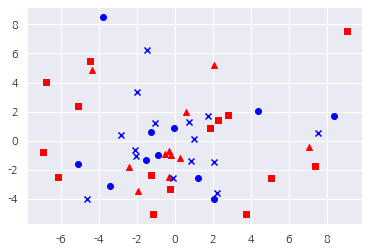

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A',marker='o')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B', marker='^')
ax.scatter(pc_X[:,0],pc_X[:,1], c='blue', label='X', marker='x')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='red', label='Y', marker='s')

# STEP 4. WEAT score 계산과 시각화

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

In [28]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    # X : art
    # Y : gen
    
    # X(art)에 대해 A 와 B 중에 누가 더 가깝냐 
    s_X = s(X, A, B) # 양수면 A 단어들이 art에 가깝다. 음수면 B 단어들이 art에 가깝다
    # Y(gen)에 대해 A 와 B 중에 누가 더 가깝냐 
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X) # A, B 가 art와의 거리
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev 
# 양수 : Y보다 X에 더 가깝다
# 음수 : X보다 Y에 더

In [53]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target['art']])
Y = np.array([model.wv[word] for word in target['gen']])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attribute[list(attribute.keys())[i]]])
        B = np.array([model.wv[word] for word in attribute[list(attribute.keys())[j]]])
        matrix[i][j] = weat_score(X, Y, A, B)


In [64]:
results_list = list()
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if abs(matrix[i][j]) >= 0.8:
            results_list.append([genre_name[i], genre_name[j],matrix[i][j]])

In [101]:
results_list = sorted(results_list, key= lambda x : x[2], reverse=True )
for a, b, score in results_list:
    print(f'{a} vs {b},{score}')
    print('\t',end='')
    if score > 0 :
        print(f'▶결론 : {a} -> 예술(art), {b} -> 일반(gen)]')
    else:
        print(f'▶결론 : {b} -> 예술(art), {a} -> 일반(gen)]')

어드벤처 vs 전쟁,1.0231881141662598
	▶결론 : 어드벤처 -> 예술(art), 전쟁 -> 일반(gen)]
가족 vs 애니메이션,0.927099883556366
	▶결론 : 가족 -> 예술(art), 애니메이션 -> 일반(gen)]
서부극(웨스턴) vs 전쟁,0.9250533580780029
	▶결론 : 서부극(웨스턴) -> 예술(art), 전쟁 -> 일반(gen)]
멜로로맨스 vs 성인물(에로),0.9149858355522156
	▶결론 : 멜로로맨스 -> 예술(art), 성인물(에로) -> 일반(gen)]
공포(호러) vs 애니메이션,0.9084294438362122
	▶결론 : 공포(호러) -> 예술(art), 애니메이션 -> 일반(gen)]
공포(호러) vs 전쟁,0.8957229852676392
	▶결론 : 공포(호러) -> 예술(art), 전쟁 -> 일반(gen)]
미스터리 vs 전쟁,0.8748757839202881
	▶결론 : 미스터리 -> 예술(art), 전쟁 -> 일반(gen)]
공포(호러) vs 다큐멘터리,0.865187406539917
	▶결론 : 공포(호러) -> 예술(art), 다큐멘터리 -> 일반(gen)]
가족 vs 뮤지컬,0.8550657629966736
	▶결론 : 가족 -> 예술(art), 뮤지컬 -> 일반(gen)]
미스터리 vs 애니메이션,0.8498052954673767
	▶결론 : 미스터리 -> 예술(art), 애니메이션 -> 일반(gen)]
드라마 vs 애니메이션,0.8452818989753723
	▶결론 : 드라마 -> 예술(art), 애니메이션 -> 일반(gen)]
공포(호러) vs 뮤지컬,0.8397587537765503
	▶결론 : 공포(호러) -> 예술(art), 뮤지컬 -> 일반(gen)]
가족 vs 다큐멘터리,0.8251227736473083
	▶결론 : 가족 -> 예술(art), 다큐멘터리 -> 일반(gen)]
공포(호러) vs 드라마,0.8213078379631042
	▶결론 : 공포(

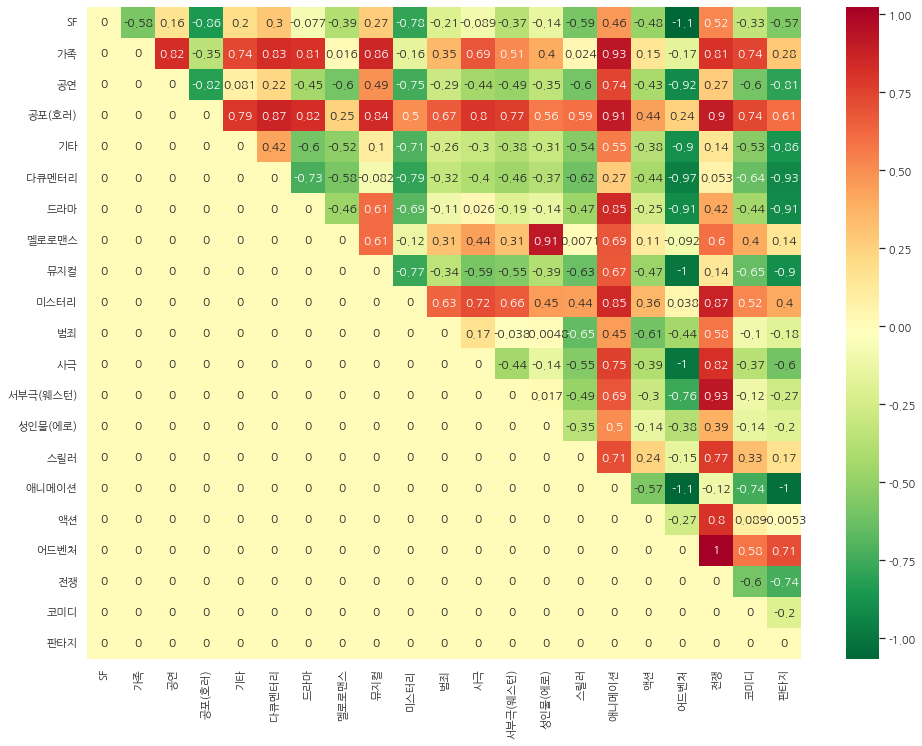

In [36]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.rcParams['axes.unicode_minus'] = False


# 새로운 그림 생성 및 크기 설정
plt.figure(figsize=(16, 12))

# 히트맵 그리기
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')

# 그림 보여주기
plt.show()


# 평가항목

|Num| 평가문항|	상세기준|
|:---:|:---|:---|
|1|주어진 영화 코퍼스를 바탕으로 `워드임베딩 모델을 정상적`으로 만들었다.	|워드임베딩의 `most_similar()` 메소드 결과가 의미상 바르게 나왔다.|
|2|영화 구분, 장르별로 `target, attribute에 대한 대표성있는 단어 셋을 생성`하였다.|	타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|
|3| `WEAT score 계산 및 시각화`를 정상적으로 진행하였다.	|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|